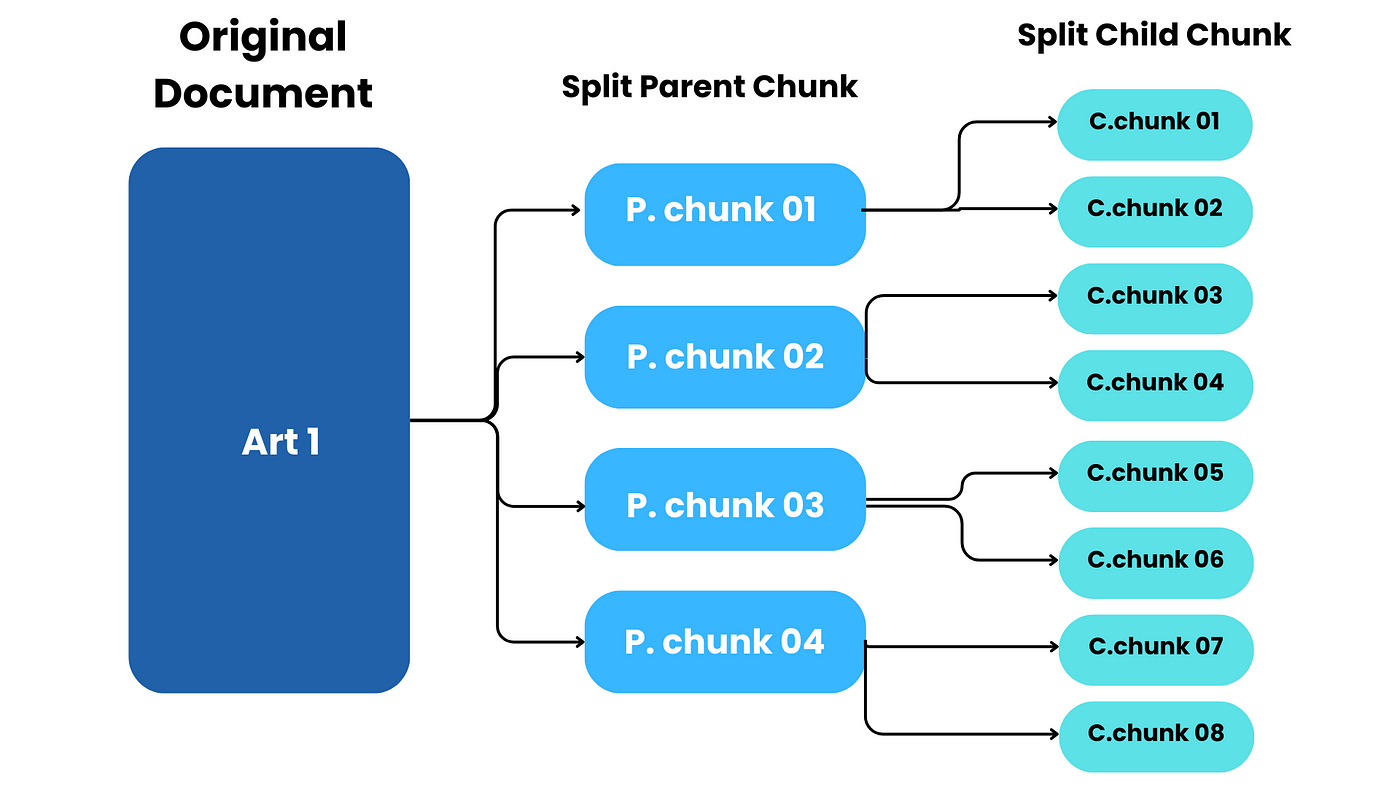

# Defaults and `init`

In [ ]:
!pip install -U "langchain==0.0.344" openai tiktoken lark datasets sentence_transformers FlagEmbedding lancedb -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
from langchain.vectorstores import LanceDB
from langchain.retrievers import ParentDocumentRetriever

#Text Splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain.docstore.document import Document

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

import os
from datasets import load_dataset

from langchain.embeddings import HuggingFaceBgeEmbeddings
import lancedb

In [ ]:
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY_HERE" # NEEDED if you run LLM Experiment below

# Embedding Functions
model_name = "BAAI/bge-small-en-v1.5" # Open Source and effective Embedding
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
bge_embeddings = HuggingFaceBgeEmbeddings(model_name=model_name,model_kwargs={'device': 'cuda'},encode_kwargs=encode_kwargs)

# Data Chunking Functions
small_chunk_splitter = RecursiveCharacterTextSplitter(chunk_size = 512) # Splitter to split documents into small chunks
big_chunk_splitter = RecursiveCharacterTextSplitter(chunk_size=2048) # Another Level of Bigger Chunks

# Lance DB Connection. Load if exists else create
my_db = lancedb.connect("./my_db")

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

# Load [Eminem Lyrics Dataset](https://huggingface.co/huggingartists/eminem)

Convert it to a `LangChain` Documents

In [ ]:
# Load a sample data here
long_texts = load_dataset("huggingartists/eminem")["train"].to_pandas().sample(100)["text"] # Data of huge context length. Use 100 random examples for demo

# Convert to LangChain Document object
docs = [Document(page_content=content, doc_id = _id, metadata = {"doc_id":_id}) for (_id, content) in enumerate(long_texts)] # List of LangChain Document Objects


Generating train split: 0 examples [00:00, ? examples/s]

# Method 1: Retrieve Parent Document

When you run a Query, match it against the **smaller** chunks and retrieve it's Parent Document for passing to LLM as a context

In [ ]:
!rm -rf ./my_db

In [ ]:
if "small_chunk_table" in my_db.table_names():
  small_chunk_table = my_db.open_table("small_chunk_table")
else: # NOTE: 384 is the size of BAAI Embedding and -999 because it's a dummy data so invalid Embedding
  small_chunk_table = my_db.create_table("small_chunk_table", data=[{"vector": [-999]*384, "text": "", "doc_id": "-1",}], mode="overwrite")

small_chunk_table.delete('doc_id = "-1"')

vectorstore = LanceDB(small_chunk_table, bge_embeddings) # Vectorstore to use to index the child chunks
store = InMemoryStore() # The storage layer for the parent documents

full_doc_retriever = ParentDocumentRetriever(vectorstore=vectorstore, docstore=store, child_splitter=small_chunk_splitter)

full_doc_retriever.add_documents(docs, ids=None) # Add all the documents

In [ ]:
# Fetch 3 most similar Smaller Documents
sub_docs = vectorstore.similarity_search("I am whatever you say I am and if I wasn't why would you say I am", k=3)

print(sub_docs[0].page_content) # This is a Smaller Chunk

Now, I dont ask nobody to share my beliefs
To be involved in my beefs
Im a man, I can stand on my feet
So if you dont wanna be in em, all I ask
Is that you dont open your mouth with an opinion
And I wont put you in em
Cause I dont ask nobody to share my beliefs
To be involved in my beefs
Im a man, I can stand on my feet
So if you dont wanna be in em, all I ask
Is that you dont open your mouth with an opinion
And I wont put you in em
Now see if you diss me and I respond, the beef is on


In [ ]:
full_docs = full_doc_retriever.get_relevant_documents("I am whatever you say I am and if I wasn't why would you say I am", k = 3)
print(full_docs[0].page_content) # This is the Parent Document returned after matching the smaller chunks internally

Girls Lyrics
Ayo, dawg, I got some shit on my motherfuckin chest
That I need to get off cause if I dont
Ima fuckin explode or somethin
Now, look, this is the story about
Some little fuckin girls that I know
It goes like this
Its so easy for me to make enemies any more, its sickening
People are lookin for an excuse to jump on my shitlist
Stickin their noses in shit that isnt none of their business
I never asked, cared, gave a fuck, or wanted opinions
Now Im in the position that I dont wanna be in shit
I never had no beef with you corny son-of-a-bitches
But now the shit is broke and you cant do nothin to fix it
So Im tellin you right now, motherfuck a Limp Bizkit
Now Ima be real, B-Real was real
He aint say shit the whole time me and Whitey was beefin, see, he chilled
He was cool with the whole situation and kept it neutral
Id have never involved my crew if it wasnt for pupils
Peoples, whatever your backpackin cipherin name is
Had I not opened a magazine and seen what you were sayin and


#  Method 2: Retrieving Larger chunks

If, small chunks are not needed as they don't have the whole context BUT the full documents are too big to be needing or fitting into LLM, we split the raw documents into larger chunks, and then split it into smaller chunks. Then index the smaller chunks, but on retrieval we retrieve the larger chunks as a replacement of full documents.

In [ ]:
if "big_chunk_table" in my_db.table_names():
  big_chunk_table = my_db.open_table("big_chunk_table")
else:
  big_chunk_table = my_db.create_table("big_chunk_table", data=[{"vector": [-999]*384, "text": "", "doc_id": "-1",}], mode="overwrite")

big_chunk_table.delete('doc_id = "-1"')

vectorstore = LanceDB(big_chunk_table, bge_embeddings)
store = InMemoryStore()

big_chunk_retriever = ParentDocumentRetriever(vectorstore=vectorstore, docstore=store,
                                              child_splitter = small_chunk_splitter,
                                              parent_splitter = big_chunk_splitter) # See one more line addition which retrieves the larger chunk instead of Parent Document

big_chunk_retriever.add_documents(docs, ids=None) # Add all the documents


In [ ]:
big_chunks_docs = big_chunk_retriever.get_relevant_documents("I am whatever you say I am and if I wasn't why would you say I am", k = 3)
print(big_chunks_docs[0].page_content) # This is the BIG chunks (in place of Parent Document) returned after matching the smaller chunks internally

This shit that I been through my pencil never could pencil
But I will never be this gullible ever again no, nope
Next time Ill know when someones copyin off me
Im not bein cocky, I just know when somebodys mockin me
I stick up my middle finger, he sticks up his finger 
I say, Fuck Christina!, he says, Fuck Christina!, but meaner
So from doin a song with Method to beggin to get accepted
Im peggin Fred with the bottle of dye that he bleached his head with
And as for Lethal, dont forget what I said
Im fuckin you up, punk, youre dead! Dont think that Im playin!
And fuck Bizkit! Cause I know youre sayin, Fuck D12!
Only not to our face, under your breath to yourselves
Little ...
Girls 
Why do you act this way? 
Why do yall act like fuckin sissies, you pussies
Keep talkin shit behind my back, you just some bitches for that
And we all know 
How fuckin cowards roll 
In fuckin Bentleys and pretend to be down
But as soon as someone calls you out
You put your tail between your legs and bow down
No

# Dummy LLM Use

In [ ]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(),
                                 chain_type="stuff",
                                 retriever=big_chunk_retriever)

In [ ]:
query = "I am whatever you say I am and if I wasn't why would you say I am? So who is Em?"
qa.run(query)